In [2]:
import os 
os.chdir("../../")

In [3]:
import glob
import numpy as np
from cids.util import metrics
from cids.util import misc_funcs as misc
from sklearn.metrics import matthews_corrcoef
from matplotlib import pyplot as plt

# Iterate Gamma

In [4]:
gammas = [0.1, 0.25, 0.5, 0.75, 1., 1.25, 1.5, 1.75, 2., 2.5, 3, 5, 10]
loss_types = ["reciprocal"] #["inverse", "reciprocal"]
lrs = [1.085e-06] # [2.17e-6, 1.085e-06]

In [5]:

runs_per_loss = {}
for loss_type, lr in zip(loss_types, lrs):
    runs = {}
    for gamma in gammas:
        run_gamma = {}
        print(f"Load run: {gamma}")
        
        result_dir = os.path.join(misc.root(), f"results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-{2 if gamma <= 2. else 3}/{loss_type}--gamma{gamma}--lr{lr}")

        aucs = []
        scores = []
        labels = []
        scores_eval = []
        labels_eval = []

        seeds = glob.glob(os.path.join(result_dir, "*"))
        print(seeds)
        for seed in seeds:
            test_scores = os.path.join(seed, "test_scores.npy")
            test_labels = os.path.join(seed, "test_labels.npy")
            eval_scores = os.path.join(seed, "eval_scores.npy")
            eval_labels = os.path.join(seed, "eval_labels.npy")
            
            score = np.load(test_scores)
            label = np.load(test_labels)
            score_eval = np.load(eval_scores)
            label_eval = np.load(eval_labels)
            
            scores.append(score)
            labels.append(label)
            scores_eval.append(score_eval)
            labels_eval.append(label_eval)

        run_gamma["seeds"] = seeds
        run_gamma["scores"] = scores
        run_gamma["labels"] = labels
        run_gamma["eval_scores"] = scores_eval
        run_gamma["eval_labels"] = labels_eval

        runs[gamma] = run_gamma
    runs_per_loss[loss_type] = runs

Load run: 0.1
['/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed1', '/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed6', '/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed10', '/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed4', '/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed2', '/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed3', '/opt/gildemeister/gildemeister-implementation/r

In [6]:
def get_threshold_iqr(run):
    scores = np.load(os.path.join(run, "train_scores.npy"))
    labels = np.load(os.path.join(run, "train_labels.npy"))

    benign_scores = scores[labels == 0]
    q1 = np.quantile(benign_scores, 0.25)
    q3 = np.quantile(benign_scores, 0.75)
    iqr = q3 - q1
    threshold = (q3 + 1.5 * iqr)
    return threshold

In [7]:
for loss_type in runs_per_loss.keys():
    runs = runs_per_loss[loss_type]
    print(runs.keys())
    for gamma in runs.keys():
        
        for prefix in [None, "eval"]:
            ts = []
            aucs = []
            rs = []
            ps = []
            f1s = []
            mccs = []
            fprs = []
            for (i, seed) in enumerate(runs[gamma]["seeds"]):
                print(seed)
                t = get_threshold_iqr(seed)
                scores = runs[gamma]["scores" if prefix is None else f"{prefix}_scores"][i]
                labels = runs[gamma]["labels" if prefix is None else f"{prefix}_labels"][i]

                tp = np.sum(scores[labels == 1] > t)
                fp = np.sum(scores[labels == 0] > t)
                fn = np.sum(scores[labels == 1] < t)
                tn = np.sum(scores[labels == 0] < t)

                f1 = metrics.f1_score(tp, fp, fn)
                recall = metrics.recall(tp, fn)
                precision = metrics.precision(tp, fp)
                fpr = metrics.fpr(fp, tn)
                mcc = matthews_corrcoef(labels, (scores > t).astype(int))
                auc = metrics.auc_score(labels, scores)

                ts.append(t)
                f1s.append(f1)
                ps.append(precision)
                rs.append(recall)
                mccs.append(mcc)
                aucs.append(auc)
                fprs.append(fpr)

            runs[gamma]["f1s" if prefix is None else f"{prefix}_f1s"] = f1s
            runs[gamma]["ps" if prefix is None else f"{prefix}_ps"] = ps
            runs[gamma]["rs" if prefix is None else f"{prefix}_rs"] = rs
            runs[gamma]["mccs" if prefix is None else f"{prefix}_mccs"] = mccs
            runs[gamma]["thresholds" if prefix is None else f"{prefix}_threshold"] = ts
            runs[gamma]["aucs" if prefix is None else f"{prefix}_aucs"] = aucs
            runs[gamma]["fprs" if prefix is None else f"{prefix}_fprs"] = fprs
    
    runs_per_loss[loss_type] = runs

dict_keys([0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.5, 3, 5, 10])
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed1
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed6
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed10
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed4
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed2
/opt/gildemeister/gildemeister-implementation/results/03_semisupervision/finetuned/MLPAE-201/SSL-FULL-ITER-201-2/reciprocal--gamma0.1--lr1.085e-06/seed3
/opt/

<>:49: SyntaxWarning: invalid escape sequence '\g'
<>:49: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_1362323/2489754812.py:49: SyntaxWarning: invalid escape sequence '\g'
  ax_test.set_xlabel("$\gamma$")


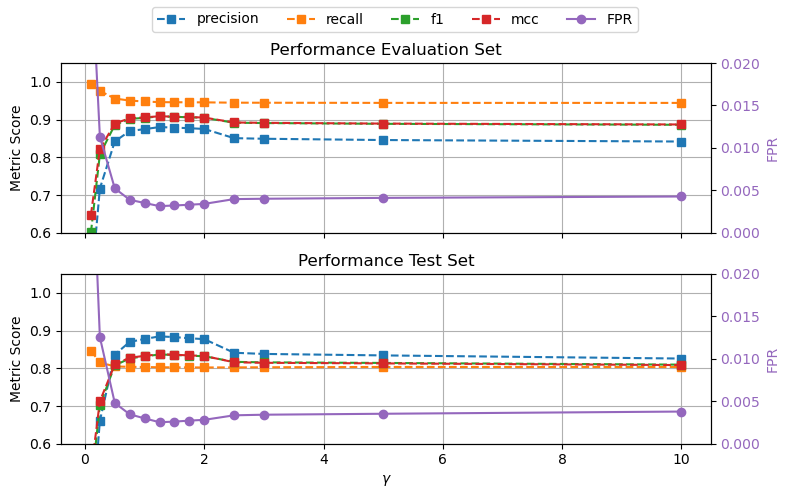

In [8]:
plt.rcParamsDefault.update({'font.size': 16})
for loss_type in runs_per_loss:
    runs = runs_per_loss[loss_type]
    
    # aggregate metrics for test (no prefix) and evaluation (with "eval_" prefix)
    test_ps, test_rs, test_f1s, test_mccs, test_fprs = [], [], [], [], []
    eval_ps, eval_rs, eval_f1s, eval_mccs, eval_fprs = [], [], [], [], []
    
    for gamma in gammas:
        test_ps.append(np.mean(runs[gamma]["ps"]))
        test_rs.append(np.mean(runs[gamma]["rs"]))
        test_f1s.append(np.mean(runs[gamma]["f1s"]))
        test_mccs.append(np.mean(runs[gamma]["mccs"]))
        test_fprs.append(np.mean(runs[gamma]["fprs"]))
        
        eval_ps.append(np.mean(runs[gamma]["eval_ps"]))
        eval_rs.append(np.mean(runs[gamma]["eval_rs"]))
        eval_f1s.append(np.mean(runs[gamma]["eval_f1s"]))
        eval_mccs.append(np.mean(runs[gamma]["eval_mccs"]))
        eval_fprs.append(np.mean(runs[gamma]["eval_fprs"]))

    # Create two subplots arranged in two rows.
    fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)
    
    # Top subplot: evaluation metrics using common labels
    ax_eval = axs[0]
    ax_eval.plot(gammas, eval_ps, marker="s", linestyle="--", label="precision")
    ax_eval.plot(gammas, eval_rs, marker="s", linestyle="--", label="recall")
    ax_eval.plot(gammas, eval_f1s, marker="s", linestyle="--", label="f1")
    ax_eval.plot(gammas, eval_mccs, marker="s", linestyle="--", label="mcc")
    ax_eval.set_ylabel("Metric Score")
    ax_eval.set_title("Performance Evaluation Set")
    ax_eval.set_ylim(0.6, 1.05)
    ax_eval.grid(True)
    ax_eval2 = ax_eval.twinx()
    # Use a less bright color, e.g., 'tab:purple'
    fpr_color = 'tab:purple'
    eval_fpr_line, = ax_eval2.plot(gammas, eval_fprs, color=fpr_color, marker="o", label="FPR")
    ax_eval2.set_ylabel("FPR", color=fpr_color)
    ax_eval2.tick_params(axis='y', labelcolor=fpr_color)
    ax_eval2.set_ylim(0, 0.02)

    # Bottom subplot: test metrics using the same labels
    ax_test = axs[1]
    ax_test.plot(gammas, test_ps, marker="s", linestyle="--", label="precision")
    ax_test.plot(gammas, test_rs, marker="s", linestyle="--", label="recall")
    ax_test.plot(gammas, test_f1s, marker="s", linestyle="--", label="f1")
    ax_test.plot(gammas, test_mccs, marker="s", linestyle="--", label="mcc")
    ax_test.set_xlabel("$\gamma$")
    ax_test.set_ylabel("Metric Score")
    ax_test.set_title("Performance Test Set")
    ax_test.set_ylim(0.6, 1.05)
    ax_test.grid(True)
    ax_test2 = ax_test.twinx()
    test_fpr_line, = ax_test2.plot(gammas, test_fprs, color=fpr_color, marker="o", label="FPR")
    ax_test2.set_ylabel("FPR", color=fpr_color)
    ax_test2.tick_params(axis='y', labelcolor=fpr_color)
    ax_test2.set_ylim(0, 0.02)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    
    # Combine legend handles from both axes
    handles1, labels1 = ax_eval.get_legend_handles_labels()
    handles2, labels2 = ax_eval2.get_legend_handles_labels()
    handles = handles1 + [eval_fpr_line]
    labels = labels1 + ["FPR"]
    fig.legend(handles, labels, loc='upper center', ncol=len(handles))
    fig.savefig("plots/performancesslgammareciprocal.pdf")
    plt.show()


<>:87: SyntaxWarning: invalid escape sequence '\g'
<>:87: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipykernel_1362323/607291319.py:87: SyntaxWarning: invalid escape sequence '\g'
  ax_test.set_xlabel("$\gamma$")


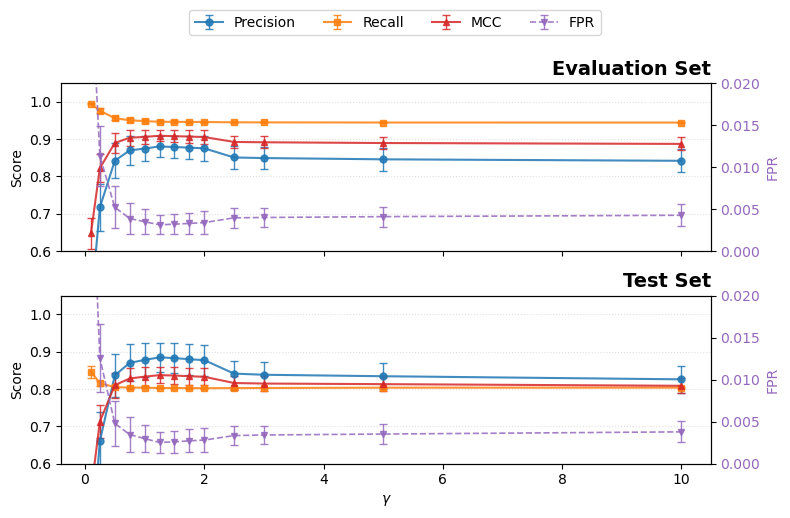

In [13]:
colors = {
    "precision": "#1f77b4",
    "recall": "#ff7f0e",
    "f1": "#2ca02c",
    "mcc": "#d62728",
    "FPR": "#9467bd"
}
markers = {
    "precision": "o",
    "recall": "s",
    "f1": "D",
    "mcc": "^",
    "FPR": "v"
}

for loss_type in runs_per_loss:
    runs = runs_per_loss[loss_type]
    test_ps, test_rs, test_f1s, test_mccs, test_fprs = [], [], [], [], []
    eval_ps, eval_rs, eval_f1s, eval_mccs, eval_fprs = [], [], [], [], []
    for gamma in gammas:
        test_ps.append(runs[gamma]["ps"])
        test_rs.append(runs[gamma]["rs"])
        test_f1s.append(runs[gamma]["f1s"])
        test_mccs.append(runs[gamma]["mccs"])
        test_fprs.append(runs[gamma]["fprs"])
        eval_ps.append(runs[gamma]["eval_ps"])
        eval_rs.append(runs[gamma]["eval_rs"])
        eval_f1s.append(runs[gamma]["eval_f1s"])
        eval_mccs.append(runs[gamma]["eval_mccs"])
        eval_fprs.append(runs[gamma]["eval_fprs"])

    test_ps = np.array(test_ps)
    test_rs = np.array(test_rs)
    test_f1s = np.array(test_f1s)
    test_mccs = np.array(test_mccs)
    test_fprs = np.array(test_fprs)
    eval_ps = np.array(eval_ps)
    eval_rs = np.array(eval_rs)
    eval_f1s = np.array(eval_f1s)
    eval_mccs = np.array(eval_mccs)
    eval_fprs = np.array(eval_fprs)

    fig, axs = plt.subplots(2, 1, figsize=(8, 5), sharex=True, sharey=True)

    # Top subplot: evaluation metrics
    ax_eval = axs[0]
    for metric, arr, label in [
        ("precision", eval_ps, "Precision"),
        ("recall", eval_rs, "Recall"),
        #("f1", eval_f1s, "F1"),
        ("mcc", eval_mccs, "MCC"),
    ]:
        ax_eval.errorbar(
            gammas, np.mean(arr, axis=1), 
            yerr=np.std(arr, axis=1) / np.sqrt(arr.shape[1]),
            marker=markers[metric], color=colors[metric], linestyle="-", linewidth=1.5, markersize=5,
            capsize=3, elinewidth=1, alpha=0.85, label=label
        )
    ax_eval.set_ylabel("Score")
    ax_eval.set_title("Evaluation Set", loc="right", fontsize=14, fontweight="bold")
    ax_eval.set_ylim(0.6, 1.05)
    ax_eval.grid(axis='y', linestyle=':', alpha=0.4)
    ax_eval2 = ax_eval.twinx()
    ax_eval2.errorbar(
        gammas, np.mean(eval_fprs, axis=1), yerr=np.std(eval_fprs, axis=1) / np.sqrt(eval_fprs.shape[1]),
        marker=markers["FPR"], color=colors["FPR"], linestyle="--", linewidth=1.2, markersize=5,
        capsize=3, elinewidth=1, alpha=0.85, label="FPR"
    )
    ax_eval2.set_ylabel("FPR", color=colors["FPR"])
    ax_eval2.tick_params(axis='y', labelcolor=colors["FPR"])
    ax_eval2.set_ylim(0, 0.02)

    # Bottom subplot: test metrics
    ax_test = axs[1]
    for metric, arr, label in [
        ("precision", test_ps, "Precision"),
        ("recall", test_rs, "Recall"),
        #("f1", test_f1s, "F1"),
        ("mcc", test_mccs, "MCC"),
    ]:
        ax_test.errorbar(
            gammas, np.mean(arr, axis=1), 
            yerr=np.std(arr, axis=1) / np.sqrt(arr.shape[1]),
            marker=markers[metric], color=colors[metric], linestyle="-", linewidth=1.5, markersize=5,
            capsize=3, elinewidth=1, alpha=0.85, label=label
        )
    ax_test.set_xlabel("$\gamma$")
    ax_test.set_ylabel("Score")
    ax_test.set_title("Test Set", loc="right", fontsize=14, fontweight="bold")
    ax_test.set_ylim(0.6, 1.05)
    ax_test.grid(axis='y', linestyle=':', alpha=0.4)
    ax_test2 = ax_test.twinx()
    ax_test2.errorbar(
        gammas, np.mean(test_fprs, axis=1), yerr=np.std(test_fprs, axis=1) / np.sqrt(test_fprs.shape[1]),
        marker=markers["FPR"], color=colors["FPR"], linestyle="--", linewidth=1.2, markersize=5,
        capsize=3, elinewidth=1, alpha=0.85, label="FPR"
    )
    ax_test2.set_ylabel("FPR", color=colors["FPR"])
    ax_test2.tick_params(axis='y', labelcolor=colors["FPR"])
    ax_test2.set_ylim(0, 0.02)

    # Legend outside plot
    lines, labels = [], []
    for ax in [ax_eval, ax_eval2]:
        l, lab = ax.get_legend_handles_labels()
        lines += l
        labels += lab
    fig.legend(lines, labels, loc='upper center', ncol=4, frameon=True, bbox_to_anchor=(0.5, 1.04))
    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    fig.savefig("plots/performancesslgammareciprocalerror.pdf", bbox_inches='tight')
    plt.show()